This notebook uses the [GPyTorch package](https://github.com/cornellius-gp/gpytorch) to apply Gaussian Process regression to the multi-step energy consumption forecasting problem.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
import torch

from sklearn.preprocessing import MinMaxScaler
from src.gaussian_process.exact import ExactGPModel, ExactGP

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
random_seed = 1923

Using the torch.float32 datatype seems to cause numerical stability issues, especially with variational inference & zero values. Using float64 and disabling mixed precision fixes them but slows down training quite a bit.

In [4]:
# Set Torch settings
torch.set_default_dtype(torch.float64)
#torch.set_float32_matmul_precision('medium')

In [5]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [6]:
data_dir = "../data/processed/"

In [7]:
df = pd.read_csv(data_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")

In [8]:
# Drop generation columns
gen_cols = df.columns.values[2:].tolist()
df = df.drop(gen_cols, axis = 1)

In [9]:
df

,time,consumption_MWh
0,2018-01-01 00:00:00,27412.81
1,2018-01-01 01:00:00,26324.39
2,2018-01-01 02:00:00,24635.32
3,2018-01-01 03:00:00,23872.12
4,2018-01-01 04:00:00,23194.89
...,...,...
52579,2023-12-31 19:00:00,35090.93
52580,2023-12-31 20:00:00,33310.94
52581,2023-12-31 21:00:00,32083.96
52582,2023-12-31 22:00:00,30469.49


## Data prep

We do not need to cyclical encode seasonal features, as we will apply periodic kernels to them.

In [10]:
# Add time columns

# Trend
df["trend"] = df.index.values

# Hour of day
df["hour"] = df.time.dt.hour + 1

# Day of week
df["dayofweek"] = df.time.dt.dayofweek + 1

# Month
df["month"] = df.time.dt.month

In [11]:
df

,time,consumption_MWh,trend,hour,dayofweek,month
0,2018-01-01 00:00:00,27412.81,0,1,1,1
1,2018-01-01 01:00:00,26324.39,1,2,1,1
2,2018-01-01 02:00:00,24635.32,2,3,1,1
3,2018-01-01 03:00:00,23872.12,3,4,1,1
4,2018-01-01 04:00:00,23194.89,4,5,1,1
...,...,...,...,...,...,...
52579,2023-12-31 19:00:00,35090.93,52579,20,7,12
52580,2023-12-31 20:00:00,33310.94,52580,21,7,12
52581,2023-12-31 21:00:00,32083.96,52581,22,7,12
52582,2023-12-31 22:00:00,30469.49,52582,23,7,12


In [12]:
# Split features & target
X = df.drop(["time", "consumption_MWh",], axis = 1).values
y = df["consumption_MWh"].values

In [13]:
# Train-test split
first_t = df[df["time"] == '2022-10-18 16:00:00'].index[0] # First prediction point
X_train_raw, X_test_raw = X[:first_t, :], X[first_t:, :]
y_train_raw, y_test_raw = y[:first_t], y[first_t:]

In [14]:
# Feature & target scaling (0-1), tensor conversion
scaler = MinMaxScaler()
X_train = torch.tensor(scaler.fit_transform(X_train_raw))
X_test = torch.tensor(scaler.transform(X_test_raw))

scaler_target = MinMaxScaler()
y_train = torch.tensor(scaler_target.fit_transform(y_train_raw.reshape(-1, 1))).squeeze(-1)
y_test = torch.tensor(scaler_target.transform(y_test_raw.reshape(-1, 1))).squeeze(-1)

In [15]:
# Subset training data to fit into GPU memory
train_size = int(24 * 365 * 1)
X_train = X_train[-train_size:, :]
y_train = y_train[-train_size:]

In [16]:
X_train.shape

torch.Size([8760, 4])

## Model training strategies

Summary of training strategies tried:
- `ExactGP` can only be trained with unbatched gradient descent. The full training data does not fit into GPU memory. Training with the last ~9k observations in the training set works quite well for predicting the first few days of the testing set. Predictions move away from the series level as the distance from the training set increases, which is expected. Could be solved by rolling online updates of training data.
- `SVGP` can be trained with with batched gradient descent. Only fits into GPU memory with few inducing points, because inducing points are unbatched, kind of defeating the purpose of using SGD. Does not fit & converge properly, likely due to reliance on inducing points.
- `VNNGP` supports batching the inducing points, essentially using the entire data as both training data & inducing points. The initial computing of the k-nearest neighbor structure (when the model is created, not trained) is slow, but can be made faster by installing the faiss package. The entire data can be used as inducing points, but training loss is inexplicably high compared to `SVGP` (200k to 2k in 15-20 epochs), and predictions fluctuate around zero seemingly randomly. Also, constant warnings for negative variances are raised. I don't know why exactly this training approach fails to learn while the exact method does quite well. My theory is that the nearest neighbor structure somehow does not work with ordered time series data.

Based on all this, we continue with the `ExactGP` method, subsetting the training data. All of the strategies above were tried with the same covariance kernel choices: A linear kernel applied to the time series index (trend dummy), and a separate periodic kernel applied to each seasonal feature (hour, day of week, month of year), all combined additively.
- Applying all kernels to just the time index failed to learn the seasonality properly.

## Model training & testing without online updates

In [17]:
# Create likelihood, model, wrapper
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)
trainer = ExactGP(model, likelihood)

Training takes a long time, so we save the model.

In [18]:
model_dir = "../models/gaussian_process/"

In [19]:
# Load saved model state
model_name = "ExactGP1.pth"
state_dict = torch.load(model_dir + model_name)
trainer.load(state_dict)

Inference is also GPU intensive with a large dataset, so we subset the testing data to the training data size.
\
Wouldn't be a problem in model deployment, as we would keep the forecast horizon short, and load the trained model parameters from a .pth file without performing training in the same run.

In [20]:
# Get predictions
preds_mean, preds_upper, preds_lower = trainer.predict(X_test[:train_size, :])

In [21]:
# Backtransform predictions to original scale
preds_mean = scaler_target.inverse_transform(preds_mean.numpy().reshape(-1, 1)).squeeze()
preds_upper = scaler_target.inverse_transform(preds_upper.numpy().reshape(-1, 1)).squeeze()
preds_lower = scaler_target.inverse_transform(preds_lower.numpy().reshape(-1, 1)).squeeze()

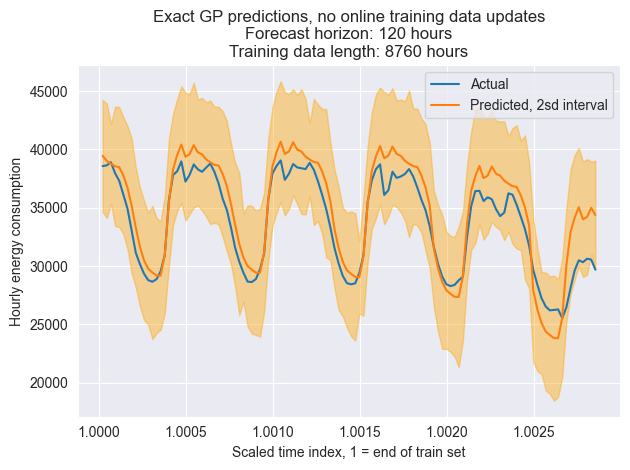

In [22]:
# Plot predicted vs. actual, first N days of testing data
plot_hours = 24 * 5

_ = sns.lineplot(
    x = X_test[:plot_hours, 0], 
    y = y_test_raw[:plot_hours], 
    label = "Actual")

_ = sns.lineplot(
    x = X_test[:plot_hours, 0], 
    y = preds_mean[:plot_hours], 
    label = "Predicted, 2sd interval")

_ = plt.fill_between(
    X_test[:plot_hours, 0], 
    preds_lower[:plot_hours], 
    preds_upper[:plot_hours], 
    color = "orange", 
    alpha = 0.4)

_ = plt.title(f"Exact GP predictions, no online training data updates\nForecast horizon: {plot_hours} hours\nTraining data length: {len(y_train)} hours")
_ = plt.xlabel("Scaled time index, 1 = end of train set")
_ = plt.ylabel("Hourly energy consumption")

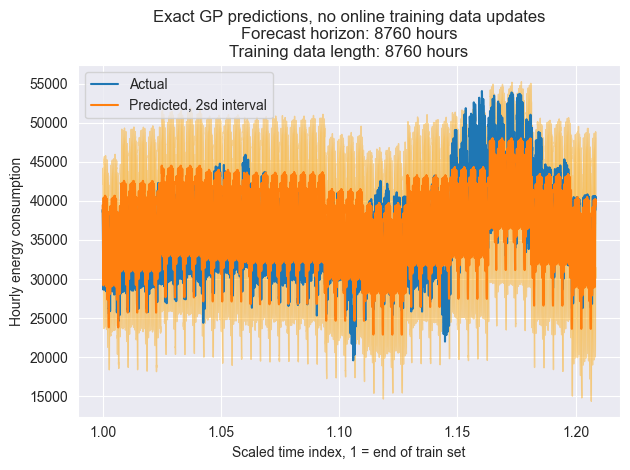

In [23]:
# Plot predicted vs. actual, entire test set
_ = sns.lineplot(
    x = X_test[:train_size, 0], 
    y = y_test_raw[:train_size], 
    label = "Actual")

_ = sns.lineplot(
    x = X_test[:train_size, 0], 
    y = preds_mean, 
    label = "Predicted, 2sd interval")

_ = plt.fill_between(
    X_test[:train_size, 0], 
    preds_lower, 
    preds_upper,
    color = "orange",
    alpha = 0.4)

_ = plt.title(f"Exact GP predictions, no online training data updates\nForecast horizon: {train_size} hours\nTraining data length: {len(y_train)} hours")
_ = plt.xlabel("Scaled time index, 1 = end of train set")
_ = plt.ylabel("Hourly energy consumption")

The initial predictions for the first few days are pretty good, and the kernels seem to be suitable for learning the seasonality of the data.
\
\
As the time index moves away from the last training point, the forecasts considerably deviate from the level of the data, but that is very natural with an effective forecast horizon of ~9k points. The lack of a past target covariate may be preventing the model from reacting to short-term cyclicality, as the LSTM and Transformer did not have this problem overall. 

## Model testing with online updates

It's possible to update the GP's training data with new data, extending its relevance to longer forecast horizons. Hyperparameters are not updated, no additional training or optimization takes place. This mirrors the usage of input sequences during prediction time in time series forecasting NN models. We condition the model on new data, essentially providing it with new context.
\
\
After each prediction, we will extend the training data in rolling fashion, with the newly predicted datapoints and the following 24 hours. This way, each new prediction starts from 16:00. 
\
\
Issue: GPU memory fills up as the model training data is updated. The loop still returns the predictions made before the GPU runs out of memory, so no need to rerun with a subset of the data. Again, this wouldn't be a problem in deployment, as we would likely do a single model update + prediction in one run, with a short horizon. We can also retrain the model with training data shifted forward in time, keeping the training data size constant as we extend it into the future.

In [24]:
# Evaluation parameters that match the sequence2sequence testing scheme
horizon = 32 # Forecast horizon
stride = 24 # Number of timesteps between each prediction point
first_t = df[df["time"] == '2022-10-18 16:00:00'].index[0] # First prediction point
last_t = df.loc[(df.time.dt.hour == 16) & (df.index + horizon - 1 <= df.index.values[-1])].index.values[-2] # Last prediction point
n_windows = len(range(first_t + 1, last_t + 1, stride)) # N. of eval windows after first

In [ ]:
# Sequence2sequence testing loop

# Initialize predictions with first forecast horizon
preds_mean, preds_upper, preds_lower = trainer.predict(X_test[:horizon, :])

# Initialize predictions' time step indices
preds_indices = X_test[:horizon, 0]

# Update model training points with predicted points & steps before next prediction point
train_end = horizon + stride
trainer.update_train(
    X_test[:train_end, :],
    y_test[:train_end]
)

# Repeat for remaining evaluation windows
for window in range(0, n_windows):

    # Make predictions
    mean, upper, lower = trainer.predict(
        X_test[train_end:(train_end + horizon), :]
    )

    # Get predictions' time step indices
    indices = X_test[train_end:(train_end + horizon), 0]

    # Concatenate predictions & indices
    preds_mean = torch.cat((preds_mean, mean))
    preds_upper = torch.cat((preds_upper, upper))
    preds_lower = torch.cat((preds_lower, lower))
    preds_indices = torch.cat((preds_indices, indices))

    # Update model training points with predicted points & steps before next prediction point
    new_train_end = train_end + horizon + stride
    trainer.update_train(
        X_test[train_end:new_train_end, :],
        y_test[train_end:new_train_end]
    )
    train_end = new_train_end

    # Delete unused tensors & clear GPU memory
    del mean, upper, lower, indices
    torch.cuda.empty_cache()

In [26]:
preds_mean.shape

torch.Size([1696])

In [27]:
preds_indices.shape

torch.Size([1696])

We're able to predict roughly ~1.7k out of the previously predicted ~9k testing observations.

In [28]:
# Backtransform predictions to original scale
preds_mean = scaler_target.inverse_transform(preds_mean.numpy().reshape(-1, 1)).squeeze()
preds_upper = scaler_target.inverse_transform(preds_upper.numpy().reshape(-1, 1)).squeeze()
preds_lower = scaler_target.inverse_transform(preds_lower.numpy().reshape(-1, 1)).squeeze()

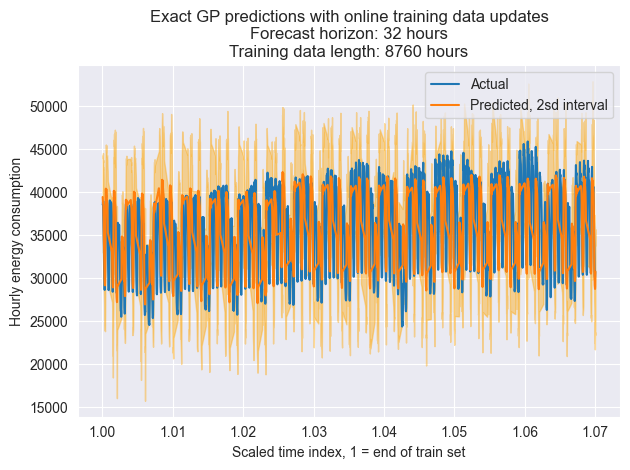

In [29]:
# Plot predicted vs. actual, entire test set
last_pred_idx = np.where(X_test[:, 0].numpy() == preds_indices[-1].numpy())[0][0]

_ = sns.lineplot(
    x = X_test[:last_pred_idx, 0], 
    y = y_test_raw[:last_pred_idx], 
    label = "Actual")

_ = sns.lineplot(
    x = preds_indices, 
    y = preds_mean, 
    label = "Predicted, 2sd interval")

_ = plt.fill_between(
    preds_indices, 
    preds_lower, 
    preds_upper, 
    color = "orange", 
    alpha = 0.4)

_ = plt.title(f"Exact GP predictions with online training data updates\nForecast horizon: {horizon} hours\nTraining data length: {len(y_train)} hours")
_ = plt.xlabel("Scaled time index, 1 = end of train set")
_ = plt.ylabel("Hourly energy consumption")

The plot is a little bit misleading, as the predicted values line (orange) is only plotted for the x-axis values where a prediction was made. The gaps, which correspond to the 24-hour stride periods without predictions, are connected with straight lines. Still, we can see the forecasts now continue to match the level of the data quite well as the predictions extend into the future. The forecast intervals also cover the actual values pretty well, which could be all one can ask for.

To sum up, the GP forecasting approach is probably best considered when:
- The training time series is not too long, or the near history is sufficient to make good predictions,
- The number of covariates is few, and the kernel choices for them are straightforward,
- Seasonality is strong & fixed (or there are other strongly predictive & easily available future covariates),
- Either a fixed trend is present, or the series level is constant,
- Cyclicality is low, or to put it another way, the additional predictive value of the past target values (or additional past covariates) are low,
- Online training data updates can be used to extend the model's relevance into the future,
- The predictions are not required real-time.